## Intro

**Cryptoweather** is an example jupyter project created for the article on Python data pipelines.

In [1]:
from datetime import datetime, timedelta
import gzip
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

## Config

### Security config

The following configuration keys are supposed to be known to the platform owner only.
They are not intended to be shared with the end users or viewers of the notebook.

In [2]:
# API KEY for weather provider
WEATHER_API_KEY = os.environ.get("WHEATHER_API_KEY")

### Presentation config

The following configuration keys are supposed to be selected by the end users or viewers. Theyr purpose to change the predefined behaviours of the notebook.

For the sake of an example we use a city and a time period's length to be selected here.

In [3]:
CITY = "Sydney"
COUNTRY = "AU"

TIME_PERIOD_DAYS=180

## Weather

In [4]:
# Download ids for cities.
all_cities = requests.get("http://bulk.openweathermap.org/sample/history.city.list.json.gz")

In [5]:
with gzip.open(io.BytesIO(all_cities.content)) as f:
    document = json.loads(f.read())
    data = [
        [d["city"]["id"]["$numberLong"], d["city"]["name"], d["city"]["country"], d["city"]["coord"]["lat"], d["city"]["coord"]["lon"]]
        for d in document
    ]

    all_cities_df = pd.DataFrame(data, columns=["id", "name", "country", "lat", "lon"])
all_cities_df.head()

,id,name,country,lat,lon
0,14256,Azadshahr,IR,34.7909,48.5707
1,18918,Protaras,CY,35.0125,34.0583
2,23814,Kahriz,IR,34.3838,47.0553
3,24851,Nurabad,IR,34.0734,47.9725
4,32723,Istgah-e Garmsar,IR,35.2345,52.3094


In [6]:
city_df = all_cities_df[
    all_cities_df["name"].map(lambda x: x == CITY) & \
    all_cities_df["country"].map(lambda x: x == COUNTRY)
][["id", "lat", "lon"]]

In [7]:
city_coord = city_df[["lat", "lon"]].values[0]
lat, lon = city_coord[0], city_coord[1]

### API Reference

https://darksky.net/dev/docs#time-machine-request

In [8]:
weather_data = []

date_start = datetime.now()
for days in range(0, TIME_PERIOD_DAYS):
    date = date_start - timedelta(days=days)
    timestamp = int(date.timestamp())
    url = f"https://api.darksky.net/forecast/{WEATHER_API_KEY}/{lat},{lon},{timestamp}?units=si&exclude=currently,minutely,hourly,alerts,flags"
    weather = requests.get(url)
    weather.raise_for_status()
    
    data = weather.json()
    weather_data.append([
        data["daily"]["data"][0]["time"],
        data["daily"]["data"][0]["temperatureMax"],
        data["daily"]["data"][0]["temperatureMin"],
        data["daily"]["data"][0]["humidity"],
        data["daily"]["data"][0]["pressure"],
        data["daily"]["data"][0]["uvIndex"],
        data["daily"]["data"][0]["visibility"],
        data["daily"]["data"][0]["moonPhase"]
    ])
    
weather_df = pd.DataFrame(
    weather_data,
    columns=["timestamp", "tempmax", "tempmin", "humidity", "pressure", "uv", "visibility", "moonphase"]
)

In [9]:
weather_df["day"] = weather_df["timestamp"].map(
    lambda x: datetime.strftime(datetime.fromtimestamp(x), "%Y-%m-%d")
)
weather_df.head()

,timestamp,tempmax,tempmin,humidity,pressure,uv,visibility,moonphase,day
0,1562508000,20.32,11.39,0.80,1023.16,2,10.323,0.21,2019-07-08
1,1562421600,19.27,11.54,0.87,1030.91,3,7.622,0.18,2019-07-07
2,1562335200,18.84,10.63,0.84,1033.99,3,9.187,0.14,2019-07-06
3,1562248800,17.47,13.32,0.86,1034.58,2,9.732,0.10,2019-07-05
4,1562162400,17.71,13.32,0.82,1033.41,2,8.791,0.06,2019-07-04


## Crypto

### API Reference

https://www.blockchain.com/api/charts_api

In [10]:
start=int((datetime.now() - timedelta(days=TIME_PERIOD_DAYS)).timestamp())
url = "https://api.blockchain.info/charts/market-price?"\
      f"timespan={TIME_PERIOD_DAYS}days&rollingAverage=24hours&format=csv&start={start}"

btc = requests.get(url)
btc.raise_for_status()

crypto_df = pd.read_csv(io.BytesIO(btc.content), names=["date", "price"])

In [11]:
crypto_df["day"] = crypto_df["date"].map(
    lambda x: x[:10]
)
crypto_df["timestamp"] = crypto_df["day"].map(
    lambda x: int(datetime.strptime(x, "%Y-%m-%d").timestamp())
)

In [12]:
crypto_df = crypto_df.sort_values(by="day", ascending=False).reset_index(drop=True)
crypto_df.head()

,date,price,day,timestamp
0,2019-07-07 00:00:00,11310.506667,2019-07-07,1562421600
1,2019-07-06 00:00:00,11411.616667,2019-07-06,1562335200
2,2019-07-05 00:00:00,11118.887500,2019-07-05,1562248800
3,2019-07-04 00:00:00,11779.450833,2019-07-04,1562162400
4,2019-07-03 00:00:00,11342.317500,2019-07-03,1562076000


## Correlation

Finally, let's calculate correlation between weather metrics and the crypto currency price.

In [13]:
combined_df = weather_df.merge(crypto_df[["day", "price"]], on="day", how="inner")
combined_df.head()

,timestamp,tempmax,tempmin,humidity,pressure,uv,visibility,moonphase,day,price
0,1562421600,19.27,11.54,0.87,1030.91,3,7.622,0.18,2019-07-07,11310.506667
1,1562335200,18.84,10.63,0.84,1033.99,3,9.187,0.14,2019-07-06,11411.616667
2,1562248800,17.47,13.32,0.86,1034.58,2,9.732,0.10,2019-07-05,11118.887500
3,1562162400,17.71,13.32,0.82,1033.41,2,8.791,0.06,2019-07-04,11779.450833
4,1562076000,18.02,7.12,0.65,1027.97,2,9.883,0.02,2019-07-03,11342.317500


In [14]:
combined_df.corr(method="spearman")

,timestamp,tempmax,tempmin,humidity,pressure,uv,visibility,moonphase,price
timestamp,1.000000,-0.785200,-0.896617,-0.077495,0.573557,-0.937682,-0.248854,0.046548,0.975371
tempmax,-0.785200,1.000000,0.847740,-0.123101,-0.555958,0.842738,0.368843,0.036386,-0.795107
tempmin,-0.896617,0.847740,1.000000,0.180001,-0.537954,0.869364,0.253791,0.009732,-0.891738
humidity,-0.077495,-0.123101,0.180001,1.000000,0.220513,-0.030018,-0.493150,-0.081941,-0.052530
pressure,0.573557,-0.555958,-0.537954,0.220513,1.000000,-0.596723,-0.197244,0.079586,0.571397
uv,-0.937682,0.842738,0.869364,-0.030018,-0.596723,1.000000,0.317980,-0.038881,-0.930137
visibility,-0.248854,0.368843,0.253791,-0.493150,-0.197244,0.317980,1.000000,-0.074683,-0.288607
moonphase,0.046548,0.036386,0.009732,-0.081941,0.079586,-0.038881,-0.074683,1.000000,0.049605
price,0.975371,-0.795107,-0.891738,-0.052530,0.571397,-0.930137,-0.288607,0.049605,1.000000


## Charts and plots

Let's pretend we see the correlation between price and the max temperature.
To highlight that, let's plot the charts for both.

In [15]:
register_matplotlib_converters()

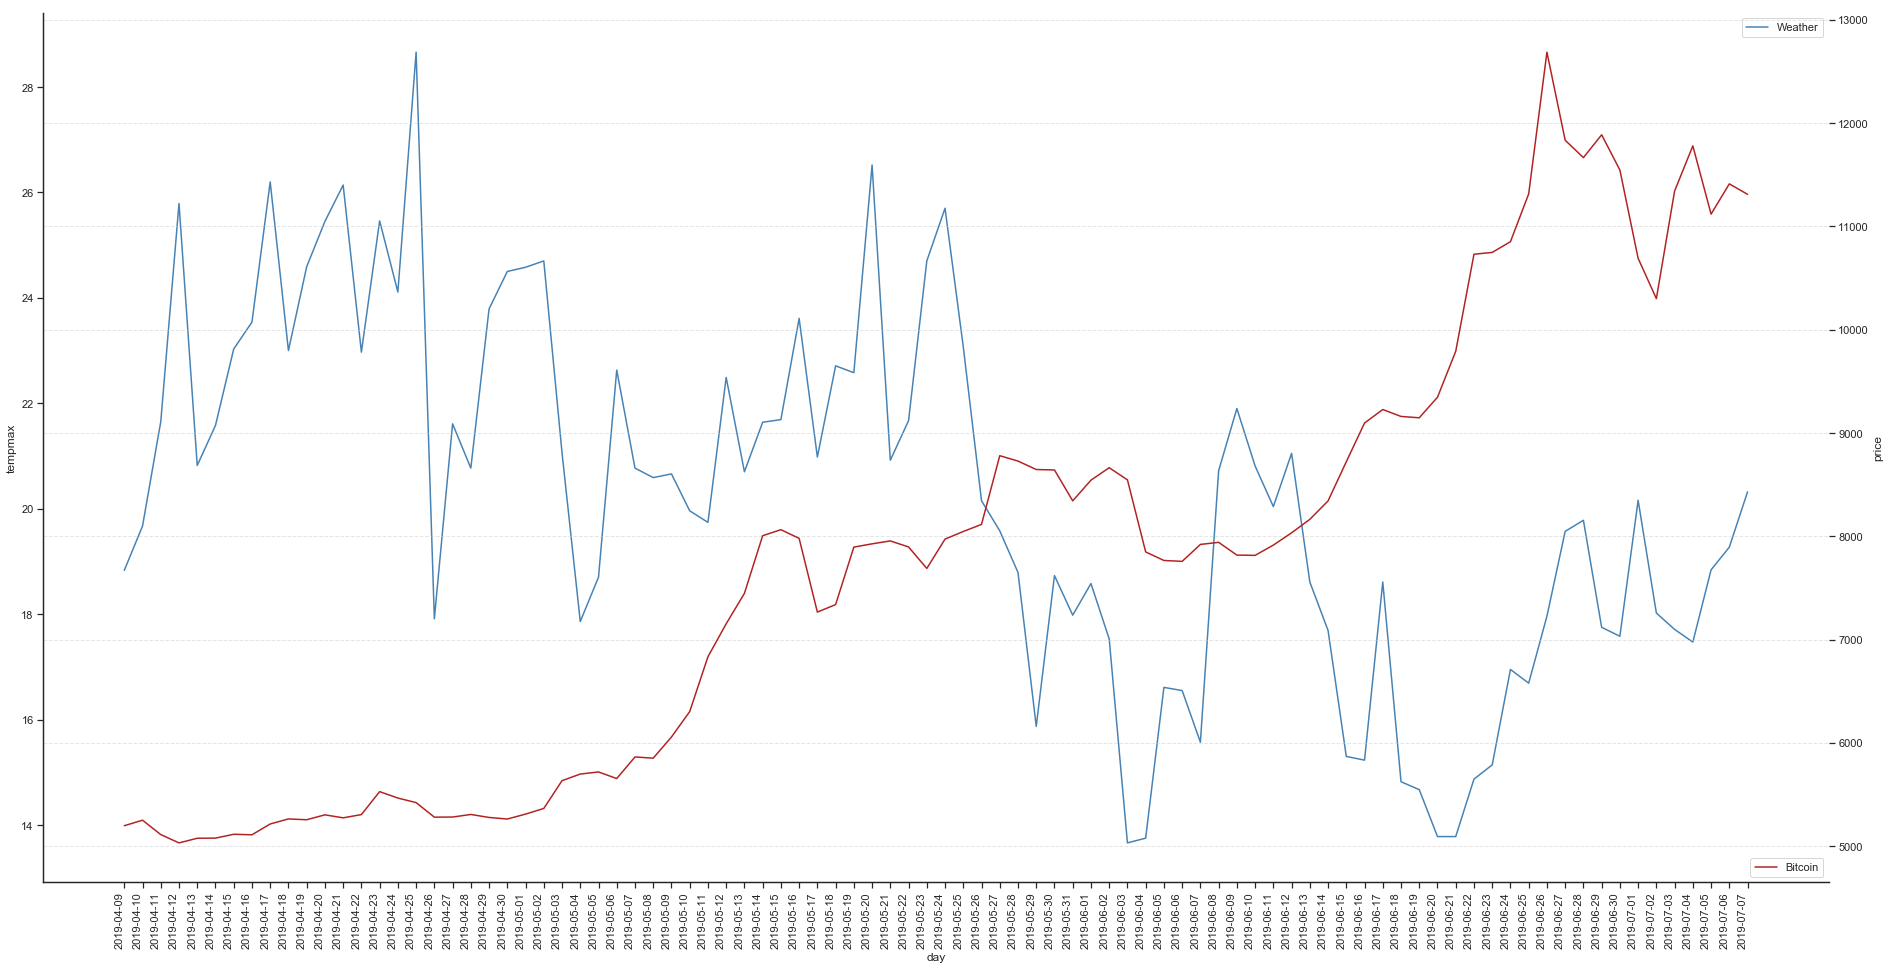

In [16]:
sns.set(style="ticks")
plt.figure(figsize=(32, 16))

figure = sns.lineplot(data=weather_df.head(90), x="day", y="tempmax", color="steelblue")

figure.set_xticklabels(figure.get_xticklabels(), rotation=90, ha="right")
figure.grid(visible=False)
figure.legend(loc="upper right", labels=["Weather"])

figure = sns.lineplot(data=crypto_df.head(90), x="day", y="price", color="firebrick", ax=plt.twinx())

figure.grid(visible=True)
figure.grid(which="minor", alpha=0.5, linestyle=":")
figure.grid(which="major", alpha=0.5, linestyle="--")
figure.legend(loc="lower right", labels=["Bitcoin"])

sns.despine()

plt.show()